<a href="https://colab.research.google.com/github/ji-hun-choi/SOTA-Study/blob/main/VGGNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms


## 데이터 불러오기

In [ ]:
import gdown
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1DtxpOUpARxcnU4qHINz9OgiOdXiji1RZ'
fname = 'hym_data.zip'
gdown.download(url, fname, quiet=False)
!unzip hym_data.zip # test를 위한 data.zip 파일 가져오기.

Downloading...
From: https://drive.google.com/uc?id=1DtxpOUpARxcnU4qHINz9OgiOdXiji1RZ
To: /content/hym_data.zip
100%|██████████| 95.0M/95.0M [00:01<00:00, 61.9MB/s]


Archive:  hym_data.zip
  inflating: hym_data/val/ants/183260961_64ab754c97.jpg  
  inflating: hym_data/val/ants/desert_ant.jpg  
  inflating: hym_data/val/ants/Ant-1818.jpg  
  inflating: hym_data/val/ants/436944325_d4925a38c7.jpg  
  inflating: hym_data/val/ants/768870506_8f115d3d37.jpg  
  inflating: hym_data/val/ants/412436937_4c2378efc2.jpg  
  inflating: hym_data/val/ants/11381045_b352a47d8c.jpg  
  inflating: hym_data/val/ants/649407494_9b6bc4949f.jpg  
  inflating: hym_data/val/ants/119785936_dd428e40c3.jpg  
  inflating: hym_data/val/ants/159515240_d5981e20d1.jpg  
  inflating: hym_data/val/ants/1119630822_cd325ea21a.jpg  
  inflating: hym_data/val/ants/172772109_d0a8e15fb0.jpg  
  inflating: hym_data/val/ants/540543309_ddbb193ee5.jpg  
  inflating: hym_data/val/ants/F.pergan.28(f).jpg  
  inflating: hym_data/val/ants/2255445811_dabcdf7258.jpg  
  inflating: hym_data/val/ants/459442412_412fecf3fe.jpg  
  inflating: hym_data/val/ants/263615709_cfb28f6b8e.jpg  
  inflating: hym_d

In [ ]:
ddir = '/content/hym_data'
batch_size = 64
num_workers = 2
data_transformers = {
    'train': transforms.Compose(
        [
         transforms.RandomResizedCrop(224), 
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
        ]
    ),
    'val': transforms.Compose(
        [
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411],[0.231, 0.221, 0.230])
        ]
    )
}

img_data = {
    k:datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
    for k in ['train', 'val']
}
dloaders = {
    k: torch.utils.data.DataLoader(
        img_data[k], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for k in ['train', 'val']
}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes

dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 모델구형 VGGNet

In [ ]:
from IPython.core.hooks import late_startup_hook
import torch
import torch.nn as nn

cfg = {
    'vgg16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'vgg19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
    }

class VGG(nn.Module):

    def __init__(self, features, num_classes=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        self.classifier(output)

        return output

def make_layers(cfg):
    layers = []

    input_channel = 3

    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue
        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]
        layers += [nn.BatchNorm2d(l)]
        layers += [nn.ReLU(inplace=True)]

        input_channel = l

    return nn.Sequential(*layers)

def vgg16(num=100):
    return VGG(make_layers(cfg['vgg16']), num_classes=num)

def vgg19(num=100):
    return VGG(make_layers(cfg['vgg19']), num_classes=num)

## train

In [ ]:
from torch.cuda import is_available
model = vgg19(2)
if torch.cuda.is_available():
    model = model.cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
def train(model, loss_func, optimizer, epochs=10):
    start = time.time()

    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print("=" * 20)

        for dset in ['train', 'val']:
            if dset == 'train':
                model.train()
            else:
                model.eval()
            loss = 0.0
            successes = 0

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optimizer.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    
                    if dset == 'train':
                        loss_curr.backward()
                        optimizer.step()
                
                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60} secs')
    print(f'Best validation set acuuracy: {accuracy}')
    return model

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pretrained_model = train(model, loss_func, optimizer, epochs=5)

Epoch number 0/4
train loss in this epoch: 8.496341736590276, accuracy in this epoch: 0.20081967213114754
val loss in this epoch: 9.989051768982332, accuracy in this epoch: 0.0
Epoch number 1/4
train loss in this epoch: 4.720672154035724, accuracy in this epoch: 0.5
val loss in this epoch: 9.611524968365439, accuracy in this epoch: 0.4575163398692811
Epoch number 2/4
train loss in this epoch: 2.421814285340856, accuracy in this epoch: 0.5286885245901639
val loss in this epoch: 8.803683293411154, accuracy in this epoch: 0.4575163398692811
Epoch number 3/4
train loss in this epoch: 1.7027083322650096, accuracy in this epoch: 0.6024590163934427
val loss in this epoch: 7.766254711774439, accuracy in this epoch: 0.4575163398692811
Epoch number 4/4
train loss in this epoch: 1.4968072742712302, accuracy in this epoch: 0.6311475409836066
val loss in this epoch: 5.930435595169566, accuracy in this epoch: 0.5882352941176471
Training finished in 0.0mins 28.104795932769775 secs
Best validation set

## test

In [ ]:
def test(model=pretrained_model):

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}


    with torch.no_grad():
        for images, labels in dloaders['val']:


            images = images.to(dvc)
            labels = labels.to(dvc)
        
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
test(pretrained_model)

Accuracy for class: ants  is 62.9 %
Accuracy for class: bees  is 55.4 %


## image 확인

In [ ]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1,2,0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

In [ ]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

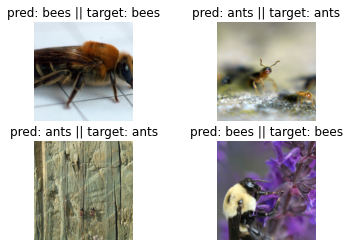

In [ ]:
visualize_predictions(pretrained_model)